# Web Data Science
## Week 12 - Automating

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT)

## Libraries

In [1]:
import numpy as np
import pandas as pd
import json, datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

import requests, json, re
from bs4 import BeautifulSoup

## Workflow

We are going to use GitHub Actions to run a scraper as a chronjob. What does that mean? 

1. We are going to write a script
2. Put the script in a GitHub repository
3. Configure the GitHub Actions to run the script
4. Sit back and watch our data slowly (but regularly!) flow in.

Almost all of these steps are going to happen *outside* of our Jupyter Notebook. We will start with some test scraping in the Notebook, but most of our time is going to be spent working with other files and the GitHub web interface. I will try to use screenshots to capture what you need to do on GitHub.

## Rotten Tomatoes scores

Rotten Tomatoes aggregates audience and critic scores for movies and television shows. These scores change over time so it could be helpful to track this with regular scraping.

### Step 1: Test scrape
Write a test scrape to orient ourselves to the relevant fields.

In [2]:
marvels_raw = requests.get('https://www.rottentomatoes.com/m/the_marvels').text

marvels_soup = BeautifulSoup(marvels_raw)

marvels_soup.find_all('score-details-critics-deprecated')

[]

Unfortunately, the scores are not static HTML elements but appear to be loaded dynamically with Javascript. In other words, we're going to have to use Selenium.

I am going to adapt some code from [this repository](https://github.com/MarketingPipeline/Python-Selenium-Action) to configure GitHub Actions to work with Selenium. In particular, I learned about the `webdriver_manager` ([docs](https://github.com/SergeyPirogov/webdriver_manager)) library that handles downloading and installing the right version of the drivers.

`pip install webdriver_manager`

Then 

`conda install selenium`

In [3]:
from selenium import webdriver

# Let Selenium control a Firefox web browser
from selenium.webdriver.firefox.service import Service as FirefoxService

from webdriver_manager.firefox import GeckoDriverManager

Download, configure, and launch the driver.

In [4]:
# Download and install the Chrome driver
firefox_service = FirefoxService(GeckoDriverManager().install())

firefox_options = webdriver.FirefoxOptions()
firefox_options.page_load_strategy = 'eager'
firefox_options.add_argument('--headless')

# Launch the driver
driver = webdriver.Firefox(options = firefox_options, service=firefox_service)

Make the request.

In [5]:
driver.get('https://www.rottentomatoes.com/m/the_marvels')

Get the source and parse to Soup.

In [6]:
# Get source
movie_raw = driver.page_source.encode('utf-8')

# Convert to Soup
movie_soup = BeautifulSoup(movie_raw)

# Quit the driver
driver.quit()

There are several tags that contain some helpful metadata.

In [7]:
# Average critics score
movie_soup.find('rt-text',{'slot':'criticsScore'}).text

'62%'

In [8]:
# Average audience score
movie_soup.find('rt-text',{'slot':'audienceScore'}).text

'81%'

In [9]:
# Number of critics reviews
movie_soup.find('rt-link',{'slot':'criticsReviews'}).text.strip()

'368 Reviews'

In [10]:
# Number of audience reviews
movie_soup.find('rt-link',{'slot':'audienceReviews'}).text.strip()

'2,500+ Verified Ratings'

Pull out the data in these tags.

In [11]:
critic_ratings_d = {}

critic_ratings_d['average_rating'] = movie_soup.find('rt-text',{'slot':'criticsScore'}).text
critic_ratings_d['reviews_count'] = movie_soup.find('rt-link',{'slot':'criticsReviews'}).text.strip()

critic_ratings_d

{'average_rating': '62%', 'reviews_count': '368 Reviews'}

In [12]:
audience_ratings_d = {}

audience_ratings_d['average_rating'] = movie_soup.find('rt-text',{'slot':'audienceScore'}).text
audience_ratings_d['reviews_count'] = movie_soup.find('rt-link',{'slot':'audienceReviews'}).text.strip()

audience_ratings_d

{'average_rating': '81%', 'reviews_count': '2,500+ Verified Ratings'}

### Step 2: Convert to a script file

We are going to create a script file (rather than a Jupyter Notebook) that will be executed by the GitHub Actions workflow. This script will emulate the functionality of what we piloted in Step 1.

Copy the code block below to a text editor and save the file as `scraper.py`.

At a terminal, navigate to the directory where you saved the file. 

Run the command `python scraper.py`

Confirm that there are two new JSON files "audience.json" and "critics.json" that were created. 

Run the script from the command line again and confirm that new (likely identical) data was appended to the previous file.

### Step 3: Set up GitHub repository

If you do not already have a GitHub account, create one: https://github.com/signup

Log into your GitHub account and create a new repository ([docs](https://docs.github.com/en/get-started/quickstart/create-a-repo)) called "RottenTomatoes".

Click the green "Code" button in your repository and select "Open with GitHub Desktop".

In the [GitHub Desktop](https://desktop.github.com/) application, change your repository to the "RottenTomatoes" repository.

Use your file explorer/finder to navigate your GitHub RottenTomatoes directory.

Copy the "scraper.py" file to your RottenTomatoes GitHub directory.

Create a new file called "requirements.txt" and paste in the text in the cell below and save the file. This requirements file will let the GitHub Actions service know what other libraries to install beyond vanilla Python.

Create a ".github/workflows" sub-directory within your RottenTomatoes GitHub directory.

If you're on a Mac, you may need to do some extra work since the Finder doesn't let you create directories that start with a period.

Inside the ".github/workflows" sub-directory, create a file named "scraper-action.yml"

Open the file, paste in the text in the cell below, and save the file.

In the GitHub Desktop application, there should be changes to three files: "requirements.txt", "scraper-action.yml", and "scraper.py". 

Enter a commit comment, click the blue "Commit to main" button, and click the "Push origin" button.

Go back to the web interface for your Repository. Click the "Actions" button at the top. 

Click the "Scraping Rotten Tomatoes" link on the side. Click the "Run workflow" drop-down and click the green "Run workflow" button.

A new row should appear in the table below titled "Scraping Rotten Tomatoes". If it is successful, there should be a green check arrow. If there are errors (red X), click the "..." button, click the "Scraping Rotten Tomatos" link, select the "build (3.10)" link under "Jobs" on the left, and you can inspect where in the chain of setup, running, commiting, etc. any errors occurred.

If it's successful, there should be two new files "audience.json" and "critics.json" in the repo and these should be updated every 10 minutes.

### Step 4: Analyze Data

Now that I've let that collect data every hour for a week, let's see what we have.

In [13]:
# Retrieve data
audience_json = requests.get('https://github.com/brianckeegan/RottenTomatoes/raw/main/audience.json').json()

# Make into a DataFrame
audience_df = pd.DataFrame(audience_json)

# Cast timestamps
audience_df['timestamp'] = pd.to_datetime(audience_df['timestamp'])

# Inspect
audience_df.head()

,timestamp,average_rating,liked_count,not_liked_count,rating_count,review_count,value
0,2023-11-20 21:12:42,4.1,2043,422,2465,1060,83
1,2023-11-20 21:47:15,4.1,2045,422,2467,1063,83
2,2023-11-20 22:17:20,4.1,2048,423,2471,1065,83
3,2023-11-21 00:25:32,4.1,2056,423,2479,1069,83
4,2023-11-21 01:37:45,4.1,2057,423,2480,1069,83


Make a plot.

<Axes: >

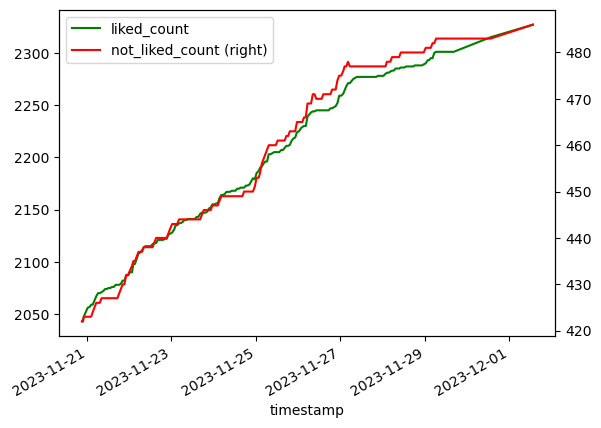

In [14]:
f,ax = plt.subplots()

audience_df.plot(x='timestamp',y='liked_count',ax=ax,c='green')
audience_df.plot(x='timestamp',y='not_liked_count',ax=ax,c='red',secondary_y=True)

Repeat for critics data.

In [15]:
len(critics_json)

NameError: name 'critics_json' is not defined

<Axes: xlabel='timestamp'>

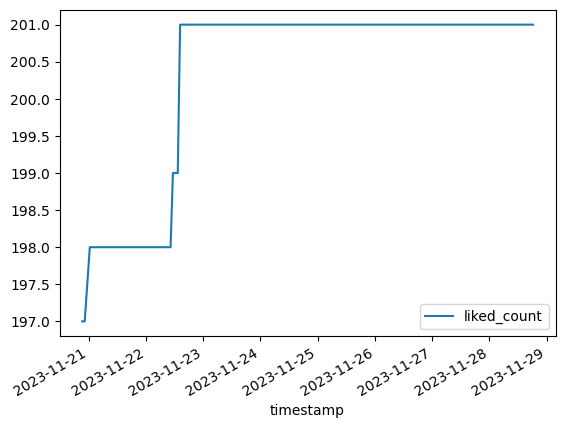

In [39]:
# Retrieve data
critics_json = requests.get('https://github.com/brianckeegan/RottenTomatoes/raw/main/critics.json').json()

# Make into a DataFrame
critics_df = pd.DataFrame(critics_json)

# Cast timestamps
critics_df['timestamp'] = pd.to_datetime(critics_df['timestamp'])

# Viusalize
critics_df.plot(x='timestamp',y='liked_count')

## Scraping top articles on Wikipedia

Wikipedia's REST API has an endpoint for the "[most views articles for a country](https://wikimedia.org/api/rest_v1/#/Pageviews%20data/get_metrics_pageviews_top_per_country__country___access___year___month___day_)" per day. We can access historical data from this API, but let's pretend that we could not and would need to scrape this API endpoint once a day.

### Step 1: Test scrape
Let's write a test API call to confirm how it works.

In [16]:
top_articles = requests.get(
    'https://wikimedia.org/api/rest_v1/metrics/pageviews/top-per-country/US/all-access/2023/11/29',
    headers={'User-Agent':'GitHub Action by Brian Keegan brian.keegan@colorado.edu'}
).json()

top_articles['items'][0]['articles'][:10]

[{'article': 'Main_Page',
  'project': 'en.wikipedia',
  'views_ceil': 1796300,
  'rank': 1},
 {'article': 'Cookie_(informatique)',
  'project': 'fr.wikipedia',
  'views_ceil': 613800,
  'rank': 2},
 {'article': 'Special:Search',
  'project': 'en.wikipedia',
  'views_ceil': 555000,
  'rank': 3},
 {'article': 'Q368215',
  'project': 'wikidata',
  'views_ceil': 200700,
  'rank': 4},
 {'article': 'Jimmy_Carter',
  'project': 'en.wikipedia',
  'views_ceil': 197000,
  'rank': 5},
 {'article': 'Charlie_Munger',
  'project': 'en.wikipedia',
  'views_ceil': 144100,
  'rank': 6},
 {'article': 'Wikipedia:首页',
  'project': 'zh.wikipedia',
  'views_ceil': 141400,
  'rank': 7},
 {'article': 'Amy_Carter',
  'project': 'en.wikipedia',
  'views_ceil': 137500,
  'rank': 8},
 {'article': 'Thank_You/en',
  'project': 'thankyou.wikipedia',
  'views_ceil': 128900,
  'rank': 9},
 {'article': 'Rosalynn_Carter',
  'project': 'en.wikipedia',
  'views_ceil': 120200,
  'rank': 10}]

### Step 2: Python-free scraping

This is a relatively straightforward data endpoint. Let's try to retrieve this data only using command line tools and without using a Python script.

The cronjob schedule string `'13 13 * * *'` [means](https://crontab.guru/#13_13_*_*_*) this script will run at 13:13 on every day.

The "Scrape data" step is a combination of several different scripts all combined together. Let's break them down.

`curl "https://wikimedia.org/api/rest_v1/metrics/pageviews/top-per-country/US/all-access/YYYY/mm/dd` requests the data from the REST API.

To fill in the date, we use the `date` function ([examples](https://www.cyberciti.biz/faq/unix-date-command-howto-see-set-date-time/)): we ask for yesterday's day (`--date "-1 days"`), and format the response to match the YYYY/mm/dd format `+%Y/%m/%d.

We pass the output from this function to a second function `jq` ([docs](https://jqlang.github.io/jq/)) which allows us to parse JSON from the command line. The `-r` option writes it directly and the `-c` option keeps it compact rather than pretty. The `'.["items"][0]'` is the basic filter/selector to retrieve items within the data.

We append the output from this step to a file "pageviews.json" with the `>>` command. ([Example](https://www.cyberciti.biz/faq/linux-append-text-to-end-of-file/))

Then we replicate the code from the previous example to commit and push the data to the repo.

In [17]:
requests.get('curl "https://wikimedia.org/api/rest_v1/metrics/pageviews/top-per-country/US/all-access/YYYY/mm/dd')

InvalidSchema: No connection adapters were found for 'curl "https://wikimedia.org/api/rest_v1/metrics/pageviews/top-per-country/US/all-access/YYYY/mm/dd'

In this Python-free example, you only need to commit the YML action file to a new repository (I called mine "[TopWikiPageviews](https://github.com/brianckeegan/TopWikiPageviews)" on your GitHub. There's no "requirements.txt" or Python script file. You can go into the Action tab and force the script to run and debug problems.

## Scraping top tracks on Spotify

I want to track the composition of Spotify's "[Top 50 - USA](https://open.spotify.com/playlist/37i9dQZEVXbLRQDuF5jeBp?si=da5fda16f67d4846)" playlist which is described as a "daily update of the most played tracks right now" in the USA.

### Step 1: Test scrape
Log in to Spotify using `spotipy` and my app credentials.

In [41]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [42]:
# I keep my keys in a file rather than the notebook
with open('spotify_keys.json','r') as f:
    creds = json.load(f)
    
manager = SpotifyClientCredentials(
    client_id = creds['client_id'],
    client_secret = creds['client_secret']
)
sp = spotipy.Spotify(client_credentials_manager = manager)

Retrieve the tracks on the playlist.

In [43]:
top50_playlist = sp.playlist_tracks('37i9dQZEVXbLRQDuF5jeBp',market='US')

Clean up the data.

In [44]:
tracks = []

for i,item in enumerate(top50_playlist['items'],start=1):
    _d = {'pos':i}
    _d['id'] = item['track']['id']
    _d['artists'] = ','.join([a['name'] for a in item['track']['artists']])
    _d['name'] = item['track']['name']
    _d['popularity'] = item['track']['popularity']
    tracks.append(_d)

# Inspect first five tracks on the playlist
tracks[:5]

[{'pos': 1,
  'id': '7ne4VBA60CxGM75vw0EYad',
  'artists': 'Gracie Abrams',
  'name': 'That’s So True',
  'popularity': 93},
 {'pos': 2,
  'id': '2plbrEY59IikOBgBGLjaoe',
  'artists': 'Lady Gaga,Bruno Mars',
  'name': 'Die With A Smile',
  'popularity': 100},
 {'pos': 3,
  'id': '3tFed7YsjGnIfxeLEQwx3R',
  'artists': 'Tyler, The Creator,GloRilla,Sexyy Red,Lil Wayne',
  'name': 'Sticky (feat. GloRilla, Sexyy Red & Lil Wayne)',
  'popularity': 88},
 {'pos': 4,
  'id': '2262bWmqomIaJXwCRHr13j',
  'artists': 'Gigi Perez',
  'name': 'Sailor Song',
  'popularity': 93},
 {'pos': 5,
  'id': '6dOtVTDdiauQNBQEDOtlAB',
  'artists': 'Billie Eilish',
  'name': 'BIRDS OF A FEATHER',
  'popularity': 97}]

### Step 2: Convert to a script file

Convert our working example from above into a self-contained script file.

One key difference that we'll discuss in Step 3 is using GitHub's features to store secrets in the repository that you can access: https://docs.github.com/en/actions/security-guides/using-secrets-in-github-actions

So rather than hard-coding our secrets into the script or using a file with the secrets that would also appear in the repo, we will store these secrets in the repo's settings as "CLIENT_ID" and "CLIENT_SECRET" and access them using Python's environmental variables: https://docs.python.org/3/library/os.html#os.environ

Copy this code to a code editor and save the file as "scraper.py"

### Step 3: Setup GitHub repository

Repeat the steps from the Rotten Tomatoes scraper to create a repository (I calleded mine "[SpotifyUSTop50](https://github.com/brianckeegan/SpotifyUSTop50)") and pull it to your local machine.

Create a new "requirements.txt" file that includes the spotipy dependency.

Create a new "action.yml" file. The key difference between what we did with Rotten Tomatoes is declaring the two environmental variables SPOTIFY_CLIENT_ID and SPOTIFY_CLIENT_SECRET to be read in from the repository.

name: Scraping Spotify Top 50

on:
  workflow_dispatch:
  schedule:
    - cron: '13 13 * * *'

permissions:
  contents: write 

jobs:
  build:
    runs-on: ubuntu-latest
    strategy:
      matrix:
        python-version: ['3.10']
    env:
      SPOTIFY_CLIENT_ID: ${{ secrets.SPOTIFY_CLIENT_ID }}
      SPOTIFY_CLIENT_SECRET: ${{ secrets.SPOTIFY_CLIENT_SECRET }}
    steps:
      - uses: actions/checkout@v3
      - name: Set up Python ${{ matrix.python-version }}
        uses: actions/setup-python@v4
        with:
          python-version: ${{ matrix.python-version }}
          repo-token: ${{ secrets.GITHUB_TOKEN }}
      - name: Install dependencies
        run: |
          python -m pip install --upgrade pip
          pip install -r requirements.txt
      - name: Scrape data
        run: |
          python scraper.py
      - name: commit
        run: |
          git config user.name "Scraping script"
          git config user.email "bkeegan@gmail.com"
          git pull
          git add *
          git commit -m "New data"
          git push

Follow the steps to create a secret for your repository: https://docs.github.com/en/actions/security-guides/using-secrets-in-github-actions

Go to your repository's web page, select Settings, and under "Secrets and variables" (on the left) selef "Actions".

Click the green "New repository secret", enter "SPOTIFY_CLIENT_ID" as the Name and copy the value of your Spotify API client ID over. Repeat with "SPOTIFY_CLIENT_SECRET" an your Spotify API client secret ID.

Add your "scraper.py" and "requirements.txt" files to the repository.

Create the ".github/workflows" sub-directory and add the "action.yml" file there.

Commit and push the local files to the repository.

Go back to the web interface for your Repository. Click the "Actions" button at the top. Click the "Scraping Spotify Top 50" link on the side. Click the "Run workflow" drop-down and click the green "Run workflow" button.

If it's successful, there should be a new file "top50.json" in the repo and these should be updated every day.

### Step 4: Analyze data

In [45]:
top50_json = requests.get('https://github.com/brianckeegan/SpotifyUSTop50/raw/main/top50.json').json()

In [46]:
top50_df = pd.concat({k:pd.DataFrame(v) for k,v in top50_json.items()}).reset_index()
top50_df.drop(columns=['level_1'],inplace=True)
top50_df.rename(columns={'level_0':'datetime'},inplace=True)
top50_df['datetime'] = pd.to_datetime(top50_df['datetime'])
top50_df

,datetime,pos,id,artists,name,popularity
0,2023-11-21 19:39:45,1,4xhsWYTOGcal8zt0J161CU,Jack Harlow,Lovin On Me,90
1,2023-11-21 19:39:45,2,4KULAymBBJcPRpk1yO4dOG,"Zach Bryan,Kacey Musgraves",I Remember Everything (feat. Kacey Musgraves),93
2,2023-11-21 19:39:45,3,3vkCueOmm7xQDoJ17W1Pm3,Mitski,My Love Mine All Mine,97
3,2023-11-21 19:39:45,4,1Iq8oo9XkmmvCQiGOfORiz,Taylor Swift,Is It Over Now? (Taylor's Version) (From The V...,95
4,2023-11-21 19:39:45,5,3rUGC1vUpkDG9CZFHMur1t,Tate McRae,greedy,100
...,...,...,...,...,...,...
18195,2024-11-19 13:23:07,46,0lizgQ7Qw35od7CYaoMBZb,Ariana Grande,Santa Tell Me,81
18196,2024-11-19 13:23:07,47,5hslUAKq9I9CG2bAulFkHN,Andy Williams,It's the Most Wonderful Time of the Year,78
18197,2024-11-19 13:23:07,48,7fveJ3pk1eSfxBdVkzdXZ0,"Morgan Wallen,ERNEST",Cowgirls (feat. ERNEST),83
18198,2024-11-19 13:23:07,49,2aYHxnMF2umAavtgBvmkY1,"Tyler, The Creator,ScHoolboy Q,Santigold",Thought I Was Dead (feat. ScHoolboy Q & Santig...,85


In [56]:
_df = top50_df.loc[top50_df['id']=='1Iq8oo9XkmmvCQiGOfORiz',['datetime','pos']].set_index('datetime')['pos']
_df.head()

datetime
2023-11-21 19:39:45     4
2023-11-22 13:21:26     5
2023-11-23 13:21:39     4
2023-11-24 13:21:01     9
2023-11-25 13:19:56    15
Name: pos, dtype: int64

Text(0.5, 1.0, "Changing ranking on Spotify's US Top 50 Playlist")

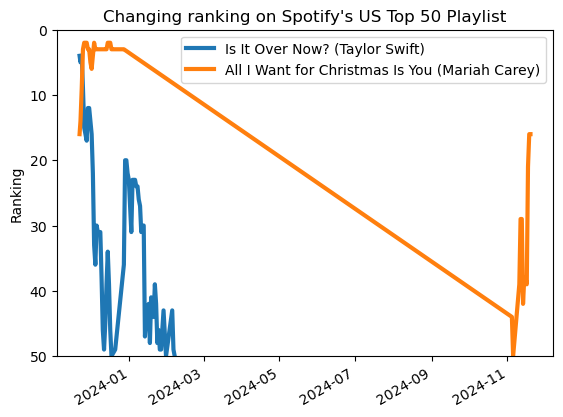

In [47]:
f,ax = plt.subplots()

top50_df[top50_df['id']=='1Iq8oo9XkmmvCQiGOfORiz'].plot(
    x='datetime',
    y='pos',
    ax=ax,
    label='Is It Over Now? (Taylor Swift)',
    lw=3
)

top50_df[top50_df['id']=='0bYg9bo50gSsH3LtXe2SQn'].plot(
    x='datetime',
    y='pos',
    ax=ax,
    label='All I Want for Christmas Is You (Mariah Carey)',
    lw=3
)

ax.set_ylim(0,50)
ax.invert_yaxis()
ax.set_ylabel('Ranking')
ax.set_xlabel(None)
ax.set_title('Changing ranking on Spotify\'s US Top 50 Playlist')

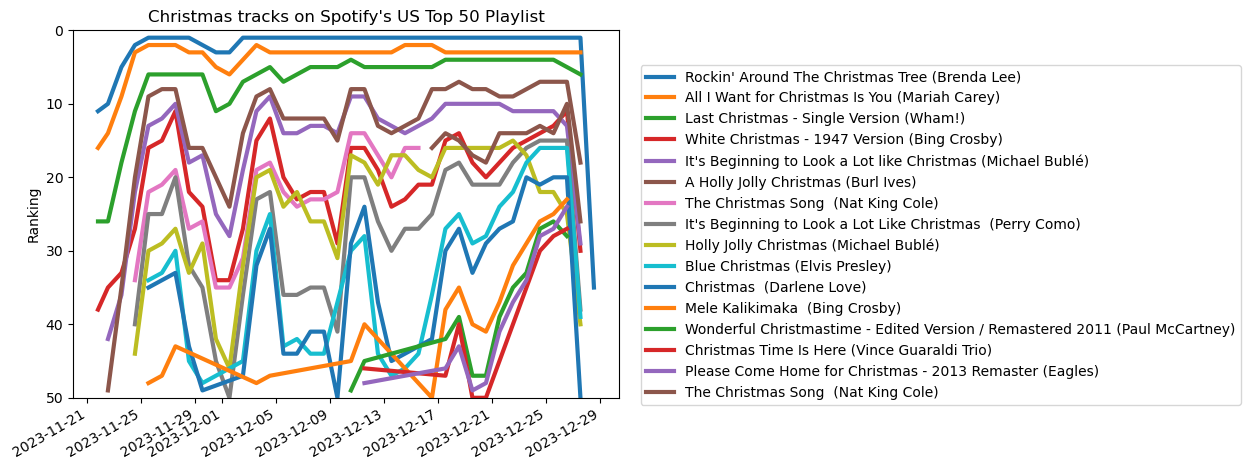

In [5]:
f,ax = plt.subplots()

christmas_tracks = top50_df.loc[top50_df['name'].isin([i for i in top50_df['name'].value_counts().index if 'Christmas' in i]),'id'].unique()

for track in christmas_tracks:
    data = top50_df[top50_df['id']==track]
    if len(data) > 10:
        track_label = re.sub(r'\([^)]*\)', '', data['name'].unique()[0])
        artist_label = data['artists'].unique()[0].split(',')[0]
        data.plot(x='datetime',y='pos',ax=ax,label="{0} ({1})".format(track_label,artist_label),lw=3,legend=False)

ax.set_ylim(0,50)
ax.invert_yaxis()
ax.set_ylabel('Ranking')
ax.set_xlabel(None)

ax.set_title('Christmas tracks on Spotify\'s US Top 50 Playlist')

f.legend(loc='center left',bbox_to_anchor=(1,.5),fontsize=10)
f.tight_layout()

f.savefig('christmas_tracks.png',bbox_inches='tight')

## Exercise

Use a headless Selenium scraper to retrieve the current jail listings for Boulder County every day and store as a CSV: https://sheriff.boco.solutions/JailOpenData/Home/JailListing